# Cross-Validation and the Bootstrap

<a target="_blank" href="https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch05-resample-lab.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intro-stat-learning/ISLP_labs/v2.2?labpath=Ch05-resample-lab.ipynb)

In this lab, we explore the resampling techniques covered in this
chapter. Some of the commands in this lab may take a while to run on
your computer.

We again begin by placing most of our imports at this top level.

In [1]:
%pip install ISLP

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 7.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5080208ffb174db223e1efeab2854689af11b0d873400887d5fe5423916a5fc4
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [2]:
import numpy as np
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)
from sklearn.model_selection import train_test_split



There are several new imports needed for this lab.

In [3]:
from functools import partial
from sklearn.model_selection import \
     (cross_validate,
      KFold,
      ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm


## The Validation Set Approach
We explore the use of the validation set approach in order to estimate
the test error rates that result from fitting various linear models on
the  `Auto`  data set.

We use the function `train_test_split()` to split
the data into training and validation sets. As there are 392 observations,
we split into two equal sets of size 196 using the
argument `test_size=196`. It is generally a good idea to set a random seed
when performing operations like this that contain an
element of randomness, so that the results obtained can be reproduced
precisely at a later time. We set the random seed of the splitter
with the argument `random_state=0`.

In [4]:
Auto = load_data('Auto')
Auto_train, Auto_valid = train_test_split(Auto,
                                         test_size=196,
                                         random_state=0)


Now we can fit a linear regression using only the observations corresponding to the training set `Auto_train`.

In [6]:
hp_mm = MS(['horsepower'])
X_train = hp_mm.fit_transform(Auto_train)
y_train = Auto_train['mpg']
model = sm.OLS(y_train, X_train)
results = model.fit()


We now use the `predict()` method of `results` evaluated on the model matrix for this model
created using the validation data set. We also calculate the validation MSE of our model.

In [7]:
X_valid = hp_mm.transform(Auto_valid)
y_valid = Auto_valid['mpg']
valid_pred = results.predict(X_valid)
np.mean((y_valid - valid_pred)**2)


np.float64(23.61661706966988)

Hence our estimate for the validation MSE of  the linear regression
fit is $23.62$.

We can also estimate the validation error for
higher-degree polynomial regressions. We first provide a function `evalMSE()` that takes a model string as well
as a training and test set and returns the MSE on the test set.

In [8]:
def evalMSE(terms,
            response,
            train,
            test):

   mm = MS(terms)
   X_train = mm.fit_transform(train)
   y_train = train[response]

   X_test = mm.transform(test)
   y_test = test[response]

   results = sm.OLS(y_train, X_train).fit()
   test_pred = results.predict(X_test)

   return np.mean((y_test - test_pred)**2)


Let’s use this function to estimate the validation MSE
using linear, quadratic and cubic fits. We use the `enumerate()`  function
here, which gives both the values and indices of objects as one iterates
over a for loop.

In [9]:
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE


array([23.61661707, 18.76303135, 18.79694163])

These error rates are $23.62, 18.76$, and $18.80$, respectively. If we
choose a different training/validation split instead, then we
can expect somewhat different errors on the validation set.

In [10]:
Auto_train, Auto_valid = train_test_split(Auto,
                                          test_size=196,
                                          random_state=3)
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    MSE[idx] = evalMSE([poly('horsepower', degree)],
                       'mpg',
                       Auto_train,
                       Auto_valid)
MSE

array([20.75540796, 16.94510676, 16.97437833])

Using this split of the observations into a training set and a validation set,
we find that the validation set error rates for the models with linear, quadratic, and cubic terms are $20.76$, $16.95$, and $16.97$, respectively.

These results are consistent with our previous findings: a model that
predicts `mpg` using a quadratic function of `horsepower`
performs better than a model that involves only a linear function of
`horsepower`, and there is no evidence of an improvement in using a cubic function of `horsepower`.

## Cross-Validation
In theory, the cross-validation estimate can be computed for any generalized
linear model.  {}
In practice, however, the simplest way to cross-validate in
Python is to use `sklearn`, which has a different interface or API
than `statsmodels`, the code we have been using to fit GLMs.

This is a problem which often confronts data scientists: "I have a function to do task $A$, and need to feed it into something that performs task $B$, so that I can compute $B(A(D))$, where $D$ is my data." When $A$ and $B$ don’t naturally speak to each other, this
requires the use of a *wrapper*.
In the `ISLP` package,
we provide
a wrapper, `sklearn_sm()`, that enables us to easily use the cross-validation tools of `sklearn` with
models fit by `statsmodels`.

The class `sklearn_sm()`
has  as its first argument
a model from `statsmodels`. It can take two additional
optional arguments: `model_str` which can be
used to specify a formula, and `model_args` which should
be a dictionary of additional arguments used when fitting
the model. For example, to fit a logistic regression model
we have to specify a `family` argument. This
is passed as `model_args={'family':sm.families.Binomial()}`.

Here is our wrapper in action:

In [11]:
hp_model = sklearn_sm(sm.OLS,
                      MS(['horsepower']))
X, Y = Auto.drop(columns=['mpg']), Auto['mpg']
cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv=Auto.shape[0])
cv_err = np.mean(cv_results['test_score'])
cv_err


np.float64(24.23151351792922)

In [13]:
print(cv_results.keys())

dict_keys(['fit_time', 'score_time', 'test_score'])


The arguments to `cross_validate()` are as follows: an
object with the appropriate `fit()`, `predict()`,
and `score()` methods,  an
array of features `X` and a response `Y`.
We also included an additional argument `cv` to `cross_validate()`; specifying an integer
$K$ results in $K$-fold cross-validation. We have provided a value
corresponding to the total number of observations, which results in
leave-one-out cross-validation (LOOCV). The `cross_validate()`  function produces a dictionary with several components;
we simply want the cross-validated test score here (MSE), which is estimated to be 24.23.

We can repeat this procedure for increasingly complex polynomial fits.
To automate the process, we again
use a for loop which iteratively fits polynomial
regressions of degree 1 to 5, computes the
associated cross-validation error, and stores it in the $i$th element
of the vector `cv_error`. The variable `d` in the for loop
corresponds to the degree of the polynomial. We begin by initializing the
vector. This command may take a couple of seconds to run.

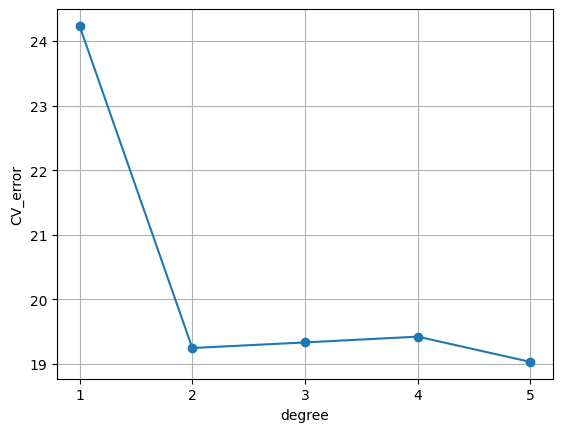

In [40]:
max_degree = 5
cv_error = np.zeros(max_degree)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,max_degree+1)):
    X = np.power.outer(H, np.arange(d+1))# creates a polynomial input with
    #powers of horsepower extending to d incl constant 1 too!
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Auto.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error
from matplotlib import pyplot as plt
plt.plot(range(1, max_degree + 1), cv_error, 'o-')
plt.xlabel('degree'); plt.ylabel('CV_error')
plt.xticks(range(1, max_degree + 1))
plt.grid()

In [38]:
cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443029, 19.03320648,
       19.00693693, 18.99513648, 23.21354558, 23.35273784, 61.29422917])

As in Figure~\ref{Ch5:cvplot}, we see a sharp drop in the estimated test MSE between the linear and
quadratic fits, but then no clear improvement from using higher-degree polynomials.

Above we introduced the `outer()`  method of the `np.power()`
function.  The `outer()` method is applied to an operation
that has two arguments, such as `add()`, `min()`, or
`power()`.
It has two arrays as
arguments, and then forms a larger
array where the operation is applied to each pair of elements of the
two arrays.

In [25]:
A = np.array([3, 5, 9])
B = np.array([2, 4])
np.power.outer(A, B)
np.zeros(H.shape)
X.shape

(392, 6)

In the CV example above, we used $K=n$, but of course we can also use $K<n$. The code is very similar
to the above (and is significantly faster). Here we use `KFold()` to partition the data into $K=10$ random groups. We use `random_state` to set a random seed and initialize a vector `cv_error` in which we will store the CV errors corresponding to the
polynomial fits of degrees one to five.

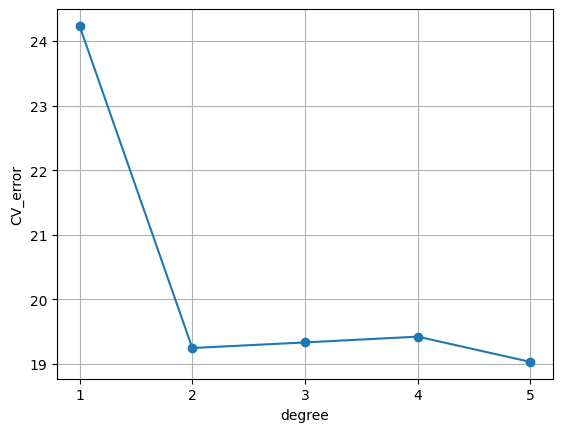

In [41]:
cv = KFold(n_splits=10,
           shuffle=True,
           random_state=0) # use same splits for each degree
cv_error = np.zeros(max_degree)
H = np.array(Auto['horsepower'])
M = sklearn_sm(sm.OLS)
for i, d in enumerate(range(1,max_degree+1)):
    X = np.power.outer(H, np.arange(d+1))# creates a polynomial input with
    #powers of horsepower extending to d incl constant 1 too!
    M_CV = cross_validate(M,
                          X,
                          Y,
                          cv=Auto.shape[0])
    cv_error[i] = np.mean(M_CV['test_score'])
cv_error
from matplotlib import pyplot as plt
plt.plot(range(1, max_degree + 1), cv_error, 'o-')
plt.xlabel('degree'); plt.ylabel('CV_error')
plt.xticks(range(1, max_degree + 1))
plt.grid()

Notice that the computation time is much shorter than that of LOOCV.
(In principle, the computation time for LOOCV for a least squares
linear model should be faster than for $K$-fold CV, due to the
availability of the formula~(\ref{Ch5:eq:LOOCVform})  for LOOCV;
however, the generic `cross_validate()`  function does not make
use of this formula.)  We still see little evidence that using cubic
or higher-degree polynomial terms leads to a lower test error than simply
using a quadratic fit.

The `cross_validate()` function is flexible and can take
different splitting mechanisms as an argument. For instance, one can use the `ShuffleSplit()` funtion to implement
the validation set approach just as easily as K-fold cross-validation.

In [42]:
validation = ShuffleSplit(n_splits=1,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation);
results['test_score']


array([23.61661707])

One can estimate the variability in the test error by running the following:

In [43]:
validation = ShuffleSplit(n_splits=10,
                          test_size=196,
                          random_state=0)
results = cross_validate(hp_model,
                         Auto.drop(['mpg'], axis=1),
                         Auto['mpg'],
                         cv=validation)
results['test_score'].mean(), results['test_score'].std()


(np.float64(23.802232661034168), np.float64(1.4218450941091842))

In [44]:
results['test_score']

array([23.61661707, 22.96552529, 23.43853845, 21.72781699, 22.79416823,
       23.09191932, 23.69196999, 23.90184611, 26.53545818, 26.258467  ])

Note that this standard deviation is not a valid estimate of the
sampling variability of the mean test score or the individual scores, since the randomly-selected training
samples overlap and hence introduce correlations. But it does give an
idea of the Monte Carlo variation
incurred by picking different random folds.

## The Bootstrap
We illustrate the use of the bootstrap in the simple example
 {of Section~\ref{Ch5:sec:bootstrap},}  as well as on an example involving
estimating the accuracy of the linear regression model on the  `Auto`
data set.
### Estimating the Accuracy of a Statistic of Interest
One of the great advantages of the bootstrap approach is that it can
be applied in almost all situations. No complicated mathematical
calculations are required. While there are several implementations
of the bootstrap in Python, its use for estimating
standard error is simple enough that we write our own function
below for the case when our data is stored
in a dataframe.

To illustrate the bootstrap, we
start with a simple example.
The  `Portfolio`  data set in the `ISLP` package is described
in Section~\ref{Ch5:sec:bootstrap}. The goal is to estimate the
sampling variance of the parameter $\alpha$ given in formula~(\ref{Ch5:min.var}).  We will
create a function
`alpha_func()`, which takes as input a dataframe `D` assumed
to have columns `X` and `Y`, as well as a
vector `idx` indicating which observations should be used to
estimate
$\alpha$. The function then outputs the estimate for $\alpha$ based on
the selected observations.

In [5]:
Portfolio = load_data('Portfolio')
def alpha_func(D, idx):
   cov_ = np.cov(D[['X','Y']].loc[idx], rowvar=False)
   return ((cov_[1,1] - cov_[0,1]) /
           (cov_[0,0]+cov_[1,1]-2*cov_[0,1]))


In [9]:
Portfolio.shape
Portfolio.index

RangeIndex(start=0, stop=100, step=1)

This function returns an estimate for $\alpha$
based on applying the minimum
    variance formula (\ref{Ch5:min.var}) to the observations indexed by
the argument `idx`.  For instance, the following command
estimates $\alpha$ using all 100 observations.

In [6]:
alpha_func(Portfolio, range(100))

np.float64(0.57583207459283)

Next we randomly select
100 observations from `range(100)`, with replacement. This is equivalent
to constructing a new bootstrap data set and recomputing $\hat{\alpha}$
based on the new data set.

In [12]:
rng = np.random.default_rng(0)
alpha_func(Portfolio,
           rng.choice(a = 100,
                      size = 100,
                      replace = True))

np.float64(0.6074452469619004)

In [13]:
rng.choice?

This process can be generalized to create a simple function `boot_SE()` for
computing the bootstrap standard error for arbitrary
functions that take only a data frame as an argument.

In [14]:
def boot_SE(func,
            D,
            n=None,
            B=1000,
            seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(a = D.index,
                         size = n,
                         replace=True)
        value = func(D, idx)
        first_ += value
        second_ += value**2
    return np.sqrt(second_ / B - (first_ / B)**2)# E[X^2] - (E[X])^2

Notice the use of `_` as a loop variable in `for _ in range(B)`. This is often used if the value of the counter is
unimportant and simply makes sure  the loop is executed `B` times.

Let’s use our function to evaluate the accuracy of our
estimate of $\alpha$ using $B=1{,}000$ bootstrap replications.

In [15]:
alpha_SE = boot_SE(alpha_func,
                   Portfolio,
                   B=1000,
                   seed=0)
alpha_SE


np.float64(0.09118176521277699)

The final output shows that the bootstrap estimate for ${\rm SE}(\hat{\alpha})$ is $0.0912$.

### Estimating the Accuracy of a Linear Regression Model
The bootstrap approach can be used to assess the variability of the
coefficient estimates and predictions from a statistical learning
method. Here we use the bootstrap approach in order to assess the
variability of the estimates for $\beta_0$ and $\beta_1$, the
intercept and slope terms for the linear regression model that uses
`horsepower` to predict `mpg` in the  `Auto`  data set. We
will compare the estimates obtained using the bootstrap to those
obtained using the formulas for ${\rm SE}(\hat{\beta}_0)$ and
${\rm SE}(\hat{\beta}_1)$ described in Section~\ref{Ch3:secoefsec}.

To use our `boot_SE()` function, we must write a function (its
first argument)
that takes a data frame `D` and indices `idx`
as its only arguments. But here we want to bootstrap a specific
regression model, specified by a model formula and data. We show how
to do this in a few simple steps.

We start by writing a generic
function `boot_OLS()` for bootstrapping a regression model that takes a formula to
define the corresponding regression. We use the `clone()` function to
make a copy of the formula that can be refit to the new dataframe. This means
that any derived features such as those defined by `poly()`
(which we will see shortly),
will be re-fit on the resampled data frame.

In [ ]:
def boot_OLS(model_matrix, response, D, idx):
    D_ = D.loc[idx]
    Y_ = D_[response]
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.OLS(Y_, X_).fit().params

This is not quite what is needed as the first argument to
`boot_SE()`. The first two arguments which specify the model will not change in the
bootstrap process, and we would like to *freeze* them.   The
function `partial()` from the `functools` module  does precisely this: it takes a function
as an argument, and freezes some of its arguments, starting from the
left. We use it to freeze the first two model-formula arguments of `boot_OLS()`.

In [ ]:
hp_func = partial(boot_OLS, MS(['horsepower']), 'mpg')


Typing `hp_func?` will show that it has two arguments `D`
and `idx` --- it is a version of `boot_OLS()` with the first
two arguments frozen --- and hence is ideal as the first argument for `boot_SE()`.

The `hp_func()` function can now be used in order to create
bootstrap estimates for the intercept and slope terms by randomly
sampling from among the observations with replacement. We first
demonstrate its utility on 10 bootstrap samples.

In [ ]:
rng = np.random.default_rng(0)
np.array([hp_func(Auto,
          rng.choice(Auto.index,
                     392,
                     replace=True)) for _ in range(10)])


array([[39.12226577, -0.1555926 ],
       [37.18648613, -0.13915813],
       [37.46989244, -0.14112749],
       [38.56723252, -0.14830116],
       [38.95495707, -0.15315141],
       [39.12563927, -0.15261044],
       [38.45763251, -0.14767251],
       [38.43372587, -0.15019447],
       [37.87581142, -0.1409544 ],
       [37.95949036, -0.1451333 ]])

Next, we use the `boot_SE()` {}  function to compute the standard
errors of 1,000 bootstrap estimates for the intercept and slope terms.

In [ ]:
hp_se = boot_SE(hp_func,
                Auto,
                B=1000,
                seed=10)
hp_se


intercept     0.731176
horsepower    0.006092
dtype: float64

This indicates that the bootstrap estimate for ${\rm SE}(\hat{\beta}_0)$ is
0.85, and that the bootstrap
estimate for ${\rm SE}(\hat{\beta}_1)$ is
0.0074.  As discussed in
Section~\ref{Ch3:secoefsec}, standard formulas can be used to compute
the standard errors for the regression coefficients in a linear
model. These can be obtained using the `summarize()`  function
from `ISLP.sm`.

In [ ]:
hp_model.fit(Auto, Auto['mpg'])
model_se = summarize(hp_model.results_)['std err']
model_se


intercept     0.717
horsepower    0.006
Name: std err, dtype: float64

The standard error estimates for $\hat{\beta}_0$ and $\hat{\beta}_1$
obtained using the formulas  from Section~\ref{Ch3:secoefsec}  are
0.717 for the
intercept and
0.006 for the
slope. Interestingly, these are somewhat different from the estimates
obtained using the bootstrap.  Does this indicate a problem with the
bootstrap? In fact, it suggests the opposite.  Recall that the
standard formulas given in
 {Equation~\ref{Ch3:se.eqn} on page~\pageref{Ch3:se.eqn}}
rely on certain assumptions. For example,
they depend on the unknown parameter $\sigma^2$, the noise
variance. We then estimate $\sigma^2$ using the RSS. Now although the
formula for the standard errors do not rely on the linear model being
correct, the estimate for $\sigma^2$ does.  We see
 {in Figure~\ref{Ch3:polyplot} on page~\pageref{Ch3:polyplot}}  that there is
a non-linear relationship in the data, and so the residuals from a
linear fit will be inflated, and so will $\hat{\sigma}^2$.  Secondly,
the standard formulas assume (somewhat unrealistically) that the $x_i$
are fixed, and all the variability comes from the variation in the
errors $\epsilon_i$.  The bootstrap approach does not rely on any of
these assumptions, and so it is likely giving a more accurate estimate
of the standard errors of $\hat{\beta}_0$ and $\hat{\beta}_1$ than
the results from `sm.OLS`.

Below we compute the bootstrap standard error estimates and the
standard linear regression estimates that result from fitting the
quadratic model to the data. Since this model provides a good fit to
the data (Figure~\ref{Ch3:polyplot}), there is now a better
correspondence between the bootstrap estimates and the standard
estimates of ${\rm SE}(\hat{\beta}_0)$, ${\rm SE}(\hat{\beta}_1)$ and
${\rm SE}(\hat{\beta}_2)$.

In [ ]:
quad_model = MS([poly('horsepower', 2, raw=True)])
quad_func = partial(boot_OLS,
                    quad_model,
                    'mpg')
boot_SE(quad_func, Auto, B=1000)


intercept                                  1.538641
poly(horsepower, degree=2, raw=True)[0]    0.024696
poly(horsepower, degree=2, raw=True)[1]    0.000090
dtype: float64

We  compare the results to the standard errors computed using `sm.OLS()`.

In [ ]:
M = sm.OLS(Auto['mpg'],
           quad_model.fit_transform(Auto))
summarize(M.fit())['std err']


intercept                                  1.800
poly(horsepower, degree=2, raw=True)[0]    0.031
poly(horsepower, degree=2, raw=True)[1]    0.000
Name: std err, dtype: float64